In [2]:
import sys
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import os
import math

from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, f1_score,mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import statsmodels.api as sm


In [3]:
#Data on Microsoft
Msft_final = pd.read_csv('MicrosoftFinalData.csv', delimiter=',')
Msft_final.dataframeName = 'MicrosoftFinalData.csv'
Msft_news = pd.read_csv('MicrosoftNewsStock.csv', delimiter=',')
Msft_news.dataframeName = 'MicrosoftNewsStock.csv'

#Data on S&P500
SNP500_data = pd.read_csv('^GSPC.csv', delimiter=',')
SNP500_data.dataframeName = '^GSPC.csv'

#Data on DJI
DJI_data = pd.read_csv('^DJI.csv', delimiter=',')
DJI_data.dataframeName = '^DJI.csv'
DJI_news = pd.read_csv('Combined_News_DJIA.csv', delimiter=',')
DJI_news.dataframeName = 'Combined_News_DJIA.csv'

#Data on Apple
Appl_final = pd.read_csv('AppleFinalData.csv', delimiter=',')
Appl_final.dataframeName = 'AppleFinalData.csv'
Appl_news = pd.read_csv('AppleNewsStock.csv', delimiter=',')
Appl_news.dataframeName = 'AppleNewsStock.csv'

In [4]:
def sentiment_value(df):
    analyser = SentimentIntensityAnalyzer()      
    if type(df)== str:
        result = analyser.polarity_scores(df)

    else:
        result = analyser.polarity_scores('')
    score = result['compound']
    return score

In [5]:
def if_news(column):
    if column == 0:
        return 0
    else:
        return 1

In [13]:
Msft_final['returns']=Msft_final['Close'].pct_change() 
Msft_final['if_news'] = Msft_final['compound'].apply(if_news)
df_weekly_Msft = Msft_final[['Date','returns', 'compound', 'neg', 'pos', 'if_news']]
df_weekly_Msft['Date'] = pd.to_datetime(df_weekly_Msft['Date'])
df_weekly_Msft.set_index('Date',inplace=True)
df_weekly_Msft = df_weekly_Msft[1:]

Appl_final['returns']=Appl_final['Close'].pct_change() 
Appl_final['if_news'] = Appl_final['compound'].apply(if_news)
df_weekly_Appl = Appl_final[['Date','returns', 'compound', 'neg', 'pos', 'if_news']]
df_weekly_Appl['Date'] = pd.to_datetime(df_weekly_Appl['Date'])
df_weekly_Appl.set_index('Date',inplace=True)
df_weekly_Appl = df_weekly_Appl[1:]

SNP500_data['returns'] = SNP500_data['Close'].pct_change()
SNP500_data['cum_returns']=SNP500_data['returns'].cumsum()
SNP500_data['Date'] = pd.to_datetime(SNP500_data['Date'])
SNP500_data.set_index('Date',inplace=True)
DJI_data['returns'] = DJI_data['Close'].pct_change()
DJI_data['cum_returns']=DJI_data['returns'].cumsum()
DJI_data['Date'] = pd.to_datetime(DJI_data['Date'])
DJI_data.set_index('Date',inplace=True)


DJI_news['Date'] = pd.to_datetime(DJI_news['Date'])


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


KeyError: 'Date'

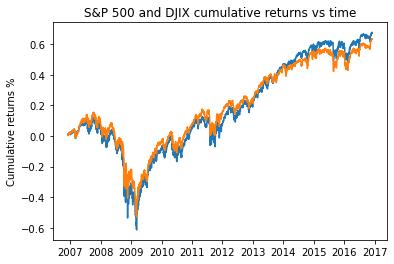

In [12]:
plt.figure()
plt.title('S&P 500 and DJIX cumulative returns vs time')
plt.ylabel('Cumulative returns %')
plt.plot(SNP500_data['cum_returns'])
plt.plot(DJI_data['cum_returns'])
plt.show()

### Checking for class imbalance

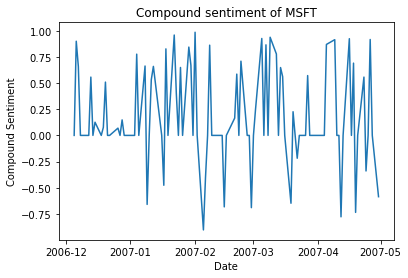

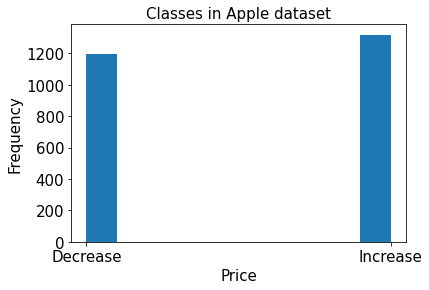

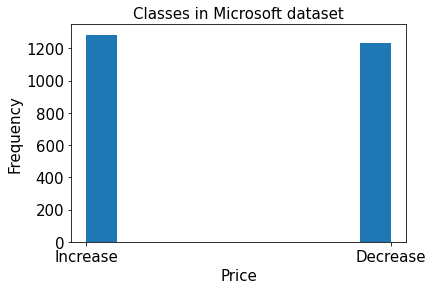

In [14]:
plt.figure(1)
plt.plot(df_weekly_Msft["compound"][1:100])
plt.xlabel("Date")
plt.ylabel("Compound Sentiment")
plt.title("Compound sentiment of MSFT")
plt.show()

df_weekly_Appl['class count'] = np.where(df_weekly_Appl['returns']>= 0,'Increase' , 'Decrease')
df_weekly_Msft['class count'] = np.where(df_weekly_Msft['returns']>= 0,'Increase' , 'Decrease')

plt.hist(df_weekly_Appl['class count'])
plt.title('Classes in Apple dataset',fontsize=15)
plt.xlabel('Price',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

plt.hist(df_weekly_Msft['class count'])
plt.title('Classes in Microsoft dataset',fontsize=15)
plt.xlabel('Price',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

### Predicting stock from News using Decession Trees

In [15]:
def decision_tree_nlp(df,train_start,train_end,test_end,pos=0):
    
    train = (train_start <= df.index) & (df.index < train_end)
    test = (train_end <= df.index) & (df.index < test_end)

    if pos == 0:
        X_train = df[['compound']][train]
        y_train = df['returns'][train]

        X_test = df[['compound']][test]
        y_test = df['returns'][test]

    else:
        X_train = df[['compound','pos']][train]
        y_train = df['returns'][train]
        X_test = df[['compound','pos']][test]
        y_test = df['returns'][test]

    clf = tree.DecisionTreeRegressor()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    pred_cum = []
    real_cum = []
    
    for i in range(len(y_pred)):
        pred_cum.append(sum(y_pred[:i])+1)
        real_cum.append(sum(y_test[:i])+1)

        
    sum_numerator = 0
    
    for i in range(len(y_pred)):
        sum_numerator += (y_test[i]-y_pred[i])**2
    
    R_Oss = 1 - ((sum_numerator)/(sum(y_test)**2))
    
    print("Mean Squared Error is", mean_squared_error(y_test, y_pred)*100,'%')
    print("R_Oos is",R_Oss*100,"%")
    
    plt.figure()
    plt.title('Cummulative returns')
    plt.plot(pred_cum,label = 'Predictions')
    plt.plot(real_cum,label = 'Actual')
    plt.legend()
    plt.show()
    
    return clf

Mean Squared Error is 0.04978195254757465 %
R_Oos is -2164.8136560098997 %


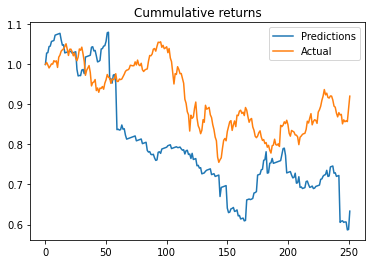

Mean Squared Error is 0.06400283686422703 %
R_Oos is -2811.7881387827847 %


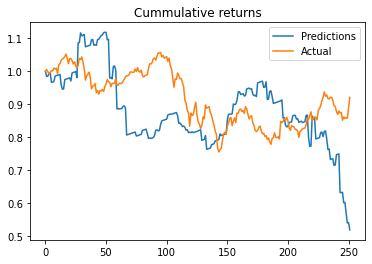

Mean Squared Error is 0.07590327929902112 %
R_Oos is 28.779490949504762 %


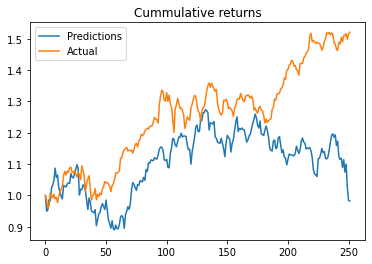

Mean Squared Error is 0.10754609757021853 %
R_Oos is -0.9111580696088417 %


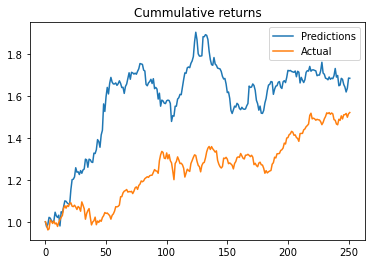

DecisionTreeRegressor()

In [17]:
decision_tree_nlp(df_weekly_Msft,'2006-12-04','2009-12-04','2010-12-04')
decision_tree_nlp(df_weekly_Msft,'2006-12-04','2009-12-04','2010-12-04',pos=1)
decision_tree_nlp(df_weekly_Appl,'2006-12-04','2009-12-04','2010-12-04')
decision_tree_nlp(df_weekly_Appl,'2006-12-04','2009-12-04','2010-12-04',pos=1)

### Predicting stock from News using Random Forest
 

In [18]:
def random_forest_nlp(X,y,train_start,train_end,test_end):
    
    train = (train_start <= X.index) & (X.index < train_end)
    test = (train_end <= X.index) & (X.index < test_end)

    #if pos == 0:
    #    X_train = df[['compound']][train]
    #    y_train = df['returns'][train]
#
#        X_test = df[['compound']][test]
#        y_test = df['returns'][test]
#
#    elif pos == -1:
#        X_train = df[['compound','neg']][train]
#        y_train = df['returns'][train]
#        X_test = df[['compound','neg']][test]
#        y_test = df['returns'][test]
#        
#    else:
    X_train = X[train]
    y_train = y[train].values.ravel()
    X_test = X[test]
    y_test = y[test].values.ravel()

        
    regr = RandomForestRegressor(max_depth=None, random_state=0)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test).ravel()

    pred_cum = []
    real_cum = []
    
    for i in range(len(y_pred)):
        pred_cum.append(sum(y_pred[:i])+1)
        real_cum.append(sum(y_test[:i])+1)
    
    sum_numerator = 0
    
    for i in range(len(y_pred)):
        sum_numerator += (y_test[i]-y_pred[i])**2
    
    R_Oss = 1 - ((sum_numerator)/(sum(y_test)**2))
    
    print("Mean Squared Error is", mean_squared_error(y_test, y_pred)*100,'%')
    print("R_Oos is",R_Oss*100,"%")

    
    plt.figure()
    plt.title('Cummulative returns')
    plt.plot(pred_cum,label = 'Predictions')
    plt.plot(real_cum,label = 'Actual')
    plt.legend()
    plt.show()
    
    return regr

Mean Squared Error is 0.045453310886816214 %
R_Oos is -1967.883518810276 %


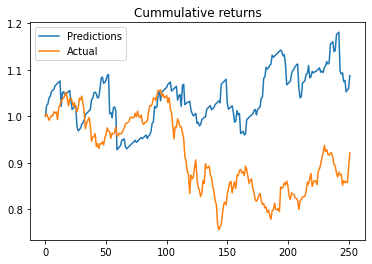

Mean Squared Error is 0.05143507276410784 %
R_Oos is 51.738158098838994 %


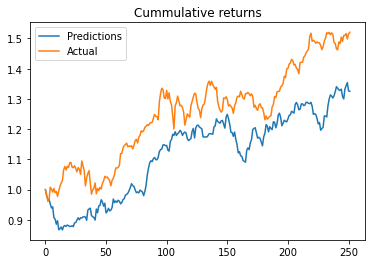

RandomForestRegressor(random_state=0)

In [19]:
X_Msft,y_Msft = df_weekly_Msft[['compound']],df_weekly_Msft[['returns']]

random_forest_nlp(X_Msft,y_Msft,'2008-12-04','2009-12-04','2010-12-04')

X_Appl,y_Appl = df_weekly_Appl[['compound']],df_weekly_Appl[['returns']]

random_forest_nlp(X_Appl,y_Appl,'2008-12-04','2009-12-04','2010-12-04')


In [20]:
def sentiment_dataframe(df,top_k_headlines):
    
    headers = (df.columns.values)[2:top_k_headlines+2]
    matrix = np.zeros([len(df),len(headers)])
    
    for k in range(len(headers)):
        for i in range(len(df)):
            matrix[i][k] = sentiment_value(df.iloc[i][k+2])
  
    dff = pd.DataFrame()
    dff = pd.DataFrame(columns = headers)
    
    j = 0
    for col in dff.columns:
        dff.loc[:, col] = matrix[:,j]
        j += 1
    dff['Date'] = df['Date']
    
    dff['Date'] = pd.to_datetime(dff['Date'])
    dff.set_index('Date',inplace=True)
    
    return dff

In [21]:
DJI_news_compound_scores = sentiment_dataframe(DJI_news,25)
DJI_news_compound_scores

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,-0.5994,0.0000,-0.3612,-0.7089,-0.9260,0.0000,-0.2732,0.2144,-0.5719,-0.5994,...,0.0000,0.0000,0.2086,0.2023,0.0258,-0.7579,-0.6249,-0.2755,-0.8519,0.4019
2008-08-11,0.8156,-0.3182,0.4404,-0.1965,0.0000,-0.4939,-0.5106,-0.0772,-0.6688,-0.3400,...,0.0000,0.0000,-0.6597,0.0000,0.0000,-0.8020,0.0000,-0.3182,-0.1832,0.0000
2008-08-12,0.0258,0.0000,-0.7845,-0.6124,0.0000,-0.6908,-0.5994,-0.5994,0.3400,-0.7650,...,0.0000,0.0000,0.0772,-0.5994,-0.5859,0.0000,0.5267,0.3818,0.0000,0.0000
2008-08-13,-0.7184,-0.8074,-0.6369,-0.1280,-0.5106,0.0000,0.2960,0.0000,0.3612,0.0000,...,0.0000,0.0000,0.0000,-0.5423,-0.0258,-0.2960,0.4939,-0.5719,-0.4215,-0.3400
2008-08-14,0.2023,0.0000,0.6808,-0.8689,-0.6124,-0.6369,0.7177,-0.4404,-0.6808,-0.3400,...,-0.6249,0.0000,0.0000,0.0000,0.0000,-0.4404,-0.5994,0.1779,-0.6908,0.7096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-27,-0.2263,0.2732,-0.6369,-0.1027,0.6369,-0.5423,-0.7096,-0.5719,-0.5859,0.0000,...,-0.5994,0.8442,-0.5994,-0.0772,0.3182,0.1724,-0.1027,-0.6249,0.2500,0.1280
2016-06-28,0.8316,-0.4588,0.4939,0.3182,-0.7717,-0.7351,0.0000,0.2960,-0.2732,0.0000,...,0.5859,-0.6124,-0.0258,0.2732,0.2263,0.0000,0.6369,0.0000,-0.7184,-0.9349
2016-06-29,0.0000,-0.6808,0.7783,-0.7430,-0.4404,0.0000,-0.8020,0.2960,0.5719,-0.1779,...,0.5994,0.0000,-0.7430,-0.8807,-0.2263,-0.9211,-0.8402,0.2023,0.0000,0.0000


In [22]:
dataset_start = '2008-08-08'
dataset_end = '2016-07-02'

df_Msft_trim = df_weekly_Msft[(dataset_start <= df_weekly_Msft.index) & (df_weekly_Msft.index < dataset_end)]
df_Appl_trim = df_weekly_Appl[(dataset_start <= df_weekly_Appl.index) & (df_weekly_Appl.index < dataset_end)]
df_SNP500_trim = SNP500_data[(dataset_start <= SNP500_data.index) & (SNP500_data.index < dataset_end)]
df_DJI_trim = DJI_data[(dataset_start <= DJI_data.index) & (DJI_data.index < dataset_end)]

In [23]:
Dataset_final = DJI_news_compound_scores
Dataset_final['Apple compound'] = df_Appl_trim['compound']
Dataset_final['Msft compound'] = df_Msft_trim['compound']
Dataset_final['DJI returns'] = df_DJI_trim['returns']
Dataset_final['S&P 500 returns'] = df_SNP500_trim['returns']
Dataset_final['Apple returns'] = df_Appl_trim['returns']
Dataset_final['Microsoft returns'] = df_Msft_trim['returns']

In [24]:
Dataset_final

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top22,Top23,Top24,Top25,Apple compound,Msft compound,DJI returns,S&P 500 returns,Apple returns,Microsoft returns
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,-0.5994,0.0000,-0.3612,-0.7089,-0.9260,0.0000,-0.2732,0.2144,-0.5719,-0.5994,...,-0.6249,-0.2755,-0.8519,0.4019,-0.9136,0.0000,0.026496,0.023893,0.036559,0.027017
2008-08-11,0.8156,-0.3182,0.4404,-0.1965,0.0000,-0.4939,-0.5106,-0.0772,-0.6688,-0.3400,...,0.0000,-0.3182,-0.1832,0.0000,0.8948,0.0000,0.004093,0.006943,0.023651,-0.008176
2008-08-12,0.0258,0.0000,-0.7845,-0.6124,0.0000,-0.6908,-0.5994,-0.5994,0.3400,-0.7650,...,0.5267,0.3818,0.0000,0.0000,0.1531,0.2023,-0.011872,-0.012051,0.018265,0.007885
2008-08-13,-0.7184,-0.8074,-0.6369,-0.1280,-0.5106,0.0000,0.2960,0.0000,0.3612,0.0000,...,0.4939,-0.5719,-0.4215,-0.3400,0.0000,-0.8074,-0.009406,-0.002916,0.014542,-0.007468
2008-08-14,0.2023,0.0000,0.6808,-0.8689,-0.6124,-0.6369,0.7177,-0.4404,-0.6808,-0.3400,...,-0.5994,0.1779,-0.6908,0.7096,0.7717,0.0000,0.007194,0.005522,0.000112,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-27,-0.2263,0.2732,-0.6369,-0.1027,0.6369,-0.5423,-0.7096,-0.5719,-0.5859,0.0000,...,-0.1027,-0.6249,0.2500,0.1280,0.1210,0.8360,-0.014971,-0.018097,-0.014561,-0.028096
2016-06-28,0.8316,-0.4588,0.4939,0.3182,-0.7717,-0.7351,0.0000,0.2960,-0.2732,0.0000,...,0.6369,0.0000,-0.7184,-0.9349,-0.2091,0.0000,0.015722,0.017770,0.016841,0.020855
2016-06-29,0.0000,-0.6808,0.7783,-0.7430,-0.4404,0.0000,-0.8020,0.2960,0.5719,-0.1779,...,-0.8402,0.2023,0.0000,0.0000,-0.2732,-0.2732,0.016368,0.017033,0.008655,0.022249


Mean Squared Error is 0.014065899842825405 %
R_Oos is -539.9235148049762 %


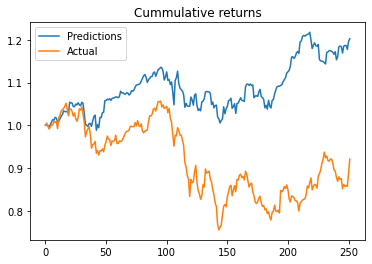

Mean Squared Error is 0.03332135610318116 %
R_Oos is -66638.48292186484 %


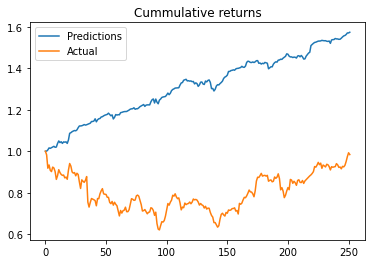

RandomForestRegressor(random_state=0)

In [25]:
X_Ms,y_Ms = Dataset_final.drop(['Microsoft returns'],axis=1),Dataset_final['Microsoft returns']

random_forest_nlp(X_Ms,y_Ms,'2008-08-08','2009-12-04','2010-12-04')

X_App,y_App = Dataset_final.drop(['Apple returns'],axis=1),Dataset_final['Apple returns']

random_forest_nlp(X_App,y_App,'2009-12-01','2012-12-04','2013-12-04')

In [31]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import he_normal

In [75]:
lamda = 0.0001     #0.0001
p = 0.1     #0.1
epochs = 20        #20

learning = 2e-4 #is good ish 0.00006
b_1 = 0.8             #0.8
b_2 = 0.999 

def train_nn(X,y,x_val,y_val,epochs=epochs,lamda=lamda,p=p,learning=learning,b_1=b_1,b_2=b_2):

    model = Sequential()
    
    model.add(Dense(30, activation='relu',
                    kernel_regularizer=l2(l=lamda), 
                    kernel_initializer=he_normal(),
                    input_dim=X.shape[1])) # number of columns
    model.add(Dropout(p))
   
    model.add(Dense(15, activation='relu',
                    kernel_regularizer=l2(l=lamda),
                    kernel_initializer=he_normal()))
    model.add(Dropout(p))

    model.add(Dense(9, activation='relu',
                    kernel_regularizer=l2(l=lamda),
                    kernel_initializer=he_normal()))
    model.add(Dropout(p))    
    
    model.add(Dense(1, activation='linear',
                    kernel_initializer=he_normal()))

    model.compile(loss='mse',
                  optimizer=Adam(learning_rate=learning, beta_1=b_1, beta_2=b_2),
                  metrics=['mse'])
    
    tf.keras.backend.set_learning_phase(True)
    history = model.fit(X,y,validation_data=(x_val, y_val),
                     epochs=epochs, batch_size=1024,
                     verbose=1)
    tf.keras.backend.set_learning_phase(False)

    return model,history

In [76]:
X_App,y_App = Dataset_final.drop(['Apple returns'],axis=1),Dataset_final['Apple returns']

Train on 255 samples, validate on 754 samples
Epoch 1/20
255/255 [==============================] - 0s 429us/sample - loss: 0.4171 - mse: 0.4070 - val_loss: 0.4157 - val_mse: 0.4057
Epoch 2/20
255/255 [==============================] - 0s 78us/sample - loss: 0.4044 - mse: 0.3944 - val_loss: 0.4028 - val_mse: 0.3928
Epoch 3/20
255/255 [==============================] - 0s 20us/sample - loss: 0.3921 - mse: 0.3820 - val_loss: 0.3903 - val_mse: 0.3803
Epoch 4/20
255/255 [==============================] - 0s 23us/sample - loss: 0.3801 - mse: 0.3700 - val_loss: 0.3781 - val_mse: 0.3681
Epoch 5/20
255/255 [==============================] - 0s 27us/sample - loss: 0.3684 - mse: 0.3583 - val_loss: 0.3663 - val_mse: 0.3562
Epoch 6/20
255/255 [==============================] - 0s 20us/sample - loss: 0.3570 - mse: 0.3470 - val_loss: 0.3548 - val_mse: 0.3448
Epoch 7/20
255/255 [==============================] - 0s 35us/sample - loss: 0.3461 - mse: 0.3360 - val_loss: 0.3437 - val_mse: 0.3337
Epoch 8/

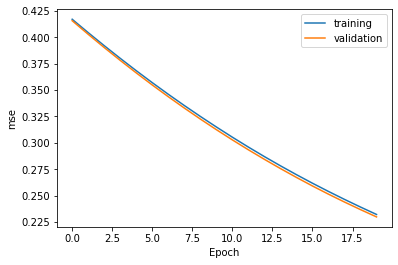

255/255 [==============================] - 0s 39us/sample - loss: 0.2255 - mse: 0.2155
Training MSE in baseline model: 0.215
754/754 [==============================] - 0s 46us/sample - loss: 0.2299 - mse: 0.2199
Out of sample testing MSE: 0.220


In [77]:
lamda = 0.009     #0.0001
p = 0.1     #0.1
epochs = 10        #20
learning = 0.00006 #is good ish 0.00006
b_1 = 0.8             #0.8
b_2 = 0.999     #0.999




train = ('2008-12-01' <= X_App.index) & (X_App.index < '2009-12-04')
vali = ('2009-12-04' <= X_App.index) & (X_App.index < '2010-12-04')
test = ('2010-12-04' <= X_App.index) & (X_App.index < '2013-12-04')

model,history = train_nn(X_App[train],y_App[train],X_App[test],y_App[test])

# visualise learning
plt.plot(history.history['loss'],label='training')
plt.plot(history.history['val_loss'],label='validation')
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# performance evaluation
metrics = model.evaluate(X_App[train],y_App[train])
mse_base = metrics[1]
print('Training MSE in baseline model: %.3f' % mse_base)

metrics = model.evaluate(X_App[test],y_App[test])
mse_OOS = metrics[1]
print('Out of sample testing MSE: %.3f' % mse_OOS)
predict = model.predict(X_App[test])



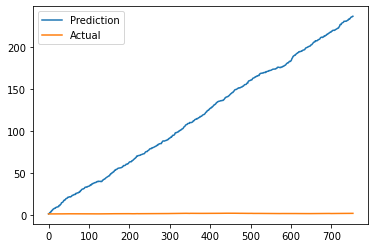

In [78]:
predict

pred_cum = []
real_cum = []

for i in range(len(predict)):
    pred_cum.append(sum(predict[:i])+1)
    real_cum.append(sum(y_App[test][:i])+1)
    
plt.figure()
plt.plot(pred_cum,label='Prediction')
plt.plot(real_cum,label='Actual')
plt.legend()
plt.show()

In [207]:

#mov_avg  = pd.DataFrame()

#for k in range(2,11):
#    
#    rolling_windows = Dataset_final['Apple compound'].rolling(k, min_periods=1)
#    rolling_mean = rolling_windows.mean()
#    
#    mov_avg['avg%d' %k] = rolling_mean[k-1:].shift()
#    
#mov_avg= mov_avg[9:500]
#mov_avg['returns'] = Dataset_final['Apple returns'][9:500]

In [206]:
#stats = []

#regs = mov_avg.drop('returns',axis=1)
#regs = regs.columns.values

#for reg in regs:
#    X = sm.add_constant(mov_avg[reg])
#    y = mov_avg['returns']
#    res = sm.OLS(y,X).fit()
#    stats.append([res.params[1],res.tvalues[1],res.rsquared])
#        
#stats = pd.DataFrame(stats,index=range(1,len(stats)+1),columns=['beta','t','R2'])
#f = stats.plot(subplots=True,figsize=(10,8))
#l = f[2].set(xlabel='Lag in regression: Excess return = a + b(lagged dp) + error') 
#plt.show()

In [264]:
X_App

,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,...,Top21,Top22,Top23,Top24,Top25,DJI returns,S&P 500 returns,Apple compound,Msft compound,Microsoft returns
Date,,,,,,,,,,,,,,,,,,,,,
2008-08-08,-0.5994,0.0000,-0.3612,-0.7089,-0.9260,0.0000,-0.2732,0.2144,-0.5719,-0.5994,...,-0.7579,-0.6249,-0.2755,-0.8519,0.4019,0.026496,0.023893,-0.9136,0.0000,0.027017
2008-08-11,0.8156,-0.3182,0.4404,-0.1965,0.0000,-0.4939,-0.5106,-0.0772,-0.6688,-0.3400,...,-0.8020,0.0000,-0.3182,-0.1832,0.0000,0.004093,0.006943,0.8948,0.0000,-0.008176
2008-08-12,0.0258,0.0000,-0.7845,-0.6124,0.0000,-0.6908,-0.5994,-0.5994,0.3400,-0.7650,...,0.0000,0.5267,0.3818,0.0000,0.0000,-0.011872,-0.012051,0.1531,0.2023,0.007885
2008-08-13,-0.7184,-0.8074,-0.6369,-0.1280,-0.5106,0.0000,0.2960,0.0000,0.3612,0.0000,...,-0.2960,0.4939,-0.5719,-0.4215,-0.3400,-0.009406,-0.002916,0.0000,-0.8074,-0.007468
2008-08-14,0.2023,0.0000,0.6808,-0.8689,-0.6124,-0.6369,0.7177,-0.4404,-0.6808,-0.3400,...,-0.4404,-0.5994,0.1779,-0.6908,0.7096,0.007194,0.005522,0.7717,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-27,-0.2263,0.2732,-0.6369,-0.1027,0.6369,-0.5423,-0.7096,-0.5719,-0.5859,0.0000,...,0.1724,-0.1027,-0.6249,0.2500,0.1280,-0.014971,-0.018097,0.1210,0.8360,-0.028096
2016-06-28,0.8316,-0.4588,0.4939,0.3182,-0.7717,-0.7351,0.0000,0.2960,-0.2732,0.0000,...,0.0000,0.6369,0.0000,-0.7184,-0.9349,0.015722,0.017770,-0.2091,0.0000,0.020855
2016-06-29,0.0000,-0.6808,0.7783,-0.7430,-0.4404,0.0000,-0.8020,0.2960,0.5719,-0.1779,...,-0.9211,-0.8402,0.2023,0.0000,0.0000,0.016368,0.017033,-0.2732,-0.2732,0.022249
